In [74]:
# for local package use
include("src/qsrfe.jl")
using Plots


In [7]:
#other datasets here
using CSV
using DataFrames
data = CSV.read("./data/AirfoilSelfNoise.csv", DataFrame)
x = data[:,1:5]
y = data[:,6]
(xtrain, xtest), (ytrain, ytest) = qsrfe.load_dataset(x,y;normalize=true,partitioning=0.8,rng=1234);

In [8]:
length(ytrain), length(ytest), length(ytrain)+ length(ytest)

(1202, 301, 1503)

In [98]:
#test cell for hyperparameter testing
#model = model
N= 2^14
λ = 0.0009 #srfe
#λ = 0.00004
model = qsrfe.srfeRegressor(N=N,λ=λ, σ2=82.0,intercept=true)

c = qsrfe.fit(model,xtrain,ytrain;verbose=true)
ytrainpred = qsrfe.predict(model,xtrain)
ytestpred = qsrfe.predict(model,xtest);

println("")
println("rel L2: ",qsrfe.rel_L2_error(ytest,ytestpred)," train rel: ",qsrfe.rel_L2_error(ytrain,ytrainpred))
println("abs: ",qsrfe.abs_error(ytest,ytestpred)," train abs: ",qsrfe.abs_error(ytrain,ytrainpred))
println("mse: ",qsrfe.mse(ytest,ytestpred)," train mse: ",qsrfe.mse(ytrain,ytrainpred))
println("rel mse: ",qsrfe.rel_mse(ytest,ytestpred)," rel train mse: ",qsrfe.rel_mse(ytrain,ytrainpred))

support: 2410/16385
rel L2: 0.019800440839232568 train rel: 0.008584926034932456
abs: 1.5313247516316615 train abs: 0.6642307449759611
mse: 6.159104716413696 train mse: 1.150619915540842
rel mse: 0.019800440839232568 rel train mse: 0.008584926034932456


In [84]:
using HyperTuning
function objective(trial)
    @unpack λ, σ2 = trial
    model = qsrfe.rfeRegressor(N=2^7,λ=λ, σ2=σ2,intercept=true)
    c = qsrfe.fit(model,xtrain,ytrain;verbose=false)
    ytestpred = qsrfe.predict(model,xtest)
    return qsrfe.mse(ytest,ytestpred)
end

scenario = Scenario(λ = (0.00000001..0.00001),
                        σ2 = (1.0..200.0),
                        max_trials = 1000);

HyperTuning.optimize(objective, scenario)

Scenario: evaluated 1000 trials.
          parameters: λ, σ2
   space cardinality: Huge!
           instances: 1
          batch_size: 28
             sampler: BCAPSampler{Random.Xoshiro}
              pruner: NeverPrune
          max_trials: 1000
           max_evals: 1000
         stop_reason: HyperTuning.BudgetExceeded("Due to max_trials")
          best_trial: 
┌───────────┬────────────┐
│     Trial │      Value │
│       824 │            │
├───────────┼────────────┤
│         λ │ 6.59125e-6 │
│        σ2 │    39.3212 │
│    Pruned │      false │
│   Success │      false │
│ Objective │    7.02974 │
└───────────┴────────────┘


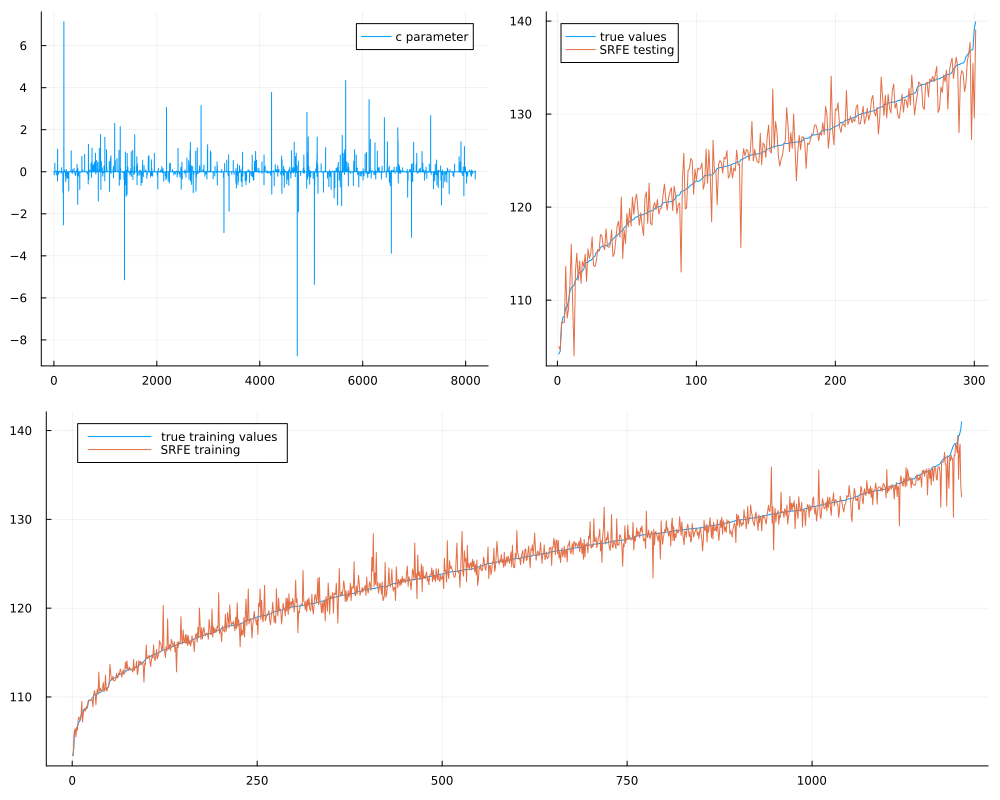

In [15]:
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[sortperm(ytrain)], label="true training values")
plot!(ytrainpred[sortperm(ytrain)], label="SRFE training")
p3 = plot(ytest[sortperm(ytest)], label="true values")
plot!(ytestpred[sortperm(ytest)], label="SRFE testing")
p4 = plot(p1,p3,layout=2, size = (1000,400))
plot(p4,p2,layout=(2,1) ,size=(1000,800))

In [39]:
trials = 5
N = [2^6, 2^7, 2^8, 2^9, 2^10, 2^11]
λ = 0.0009

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=82.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 64: 

avg. test error: 0.024001892295885497 avg. train error: 0.022082881535048747
abs. test error:2.988560884061841 abs. train error: 2.737824148368173
mse. test error:15.787334356717585 mse train error: 12.858286214639293
rel mse test error:0.03165214864272088 rel mse train error: 0.028684858805289825
current iter: 128: 

avg. test error: 0.018278646412304547 avg. train error: 0.015988053640994298
abs. test error:2.2822845455715544 abs. train error: 1.9883703093831548
mse. test error:9.819505862390791 mse train error: 6.886416572726715
rel mse test error:0.024989269886492936 rel mse train error: 0.020998016570236845
current iter: 256: 

avg. test error: 0.014897174155591681 avg. train error: 0.01155495928385977
abs. test error:1.8607084548466215 abs. train error: 1.4416832996807174
mse. test error:7.1957063182427605 mse train error: 3.840586288913445
rel mse test error:0.02137241616499174 rel mse train error: 0.01568102354259621
current iter: 512: 

avg. test error: 0.014160700848745456 avg. train error: 0.009287954271231792
abs. test error:1.7650630437911972 abs. train error: 1.1612804668209167
mse. test error:6.560998363919994 mse train error: 2.6315571966159172
rel mse test error:0.02038668848002425 rel mse train error: 0.012981941763422964
current iter: 1024: 

avg. test error: 0.01356376617802114 avg. train error: 0.007898485061861315
abs. test error:1.6860841420759929 abs. train error: 0.9881083178156616
mse. test error:6.062953311828586 mse train error: 2.01278394122527
rel mse test error:0.019595272360157134 rel mse train error: 0.011352069002875397
current iter: 2048

: avg. test error: 0.012572122230969601 avg. train error: 0.0069471859595256705
abs. test error:1.565252607987699 abs. train error: 0.8696917889581492
mse. test error:5.1548172873380675 mse train error: 1.6547612120055764
rel mse test error:0.01809514666952603 rel mse train error: 0.010294862237287424


In [40]:
trials = 5
N = [2^12]
λ = 0.0009

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=82.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 4096: 

avg. test error: 0.012002291083102612 avg. train error: 0.006166796885920994
abs. test error:1.4901535852534025 abs. train error: 0.7720612962507905
mse. test error:4.595434208376611 mse train error: 1.397303843781522
rel mse test error:0.017088425072583062 rel mse train error: 0.009460257788221956


In [38]:
trials = 5
N = [2^13]
λ = 0.001

for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=82.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 8192: avg. test error: 0.011573912512096727 avg. train error: 0.005821619561544958
abs. test error:1.4377369535511162 abs. train error: 0.7294002585641052
mse. test error:4.25684387080749 mse train error: 1.2896206568850115
rel mse test error:0.01644703670838852 rel mse train error: 0.009088185515926292


In [91]:
#RFE

trials = 5
N = [2^6, 2^7, 2^8, 2^9, 2^10, 2^11,2^12]
λ = 0.0011
i = 0
for n in N
    i += 1
    print("current iter: ",n,": ")
    model = qsrfe.rfeRegressor(N=n,λ=λ * (√(2))^(i-4), σ2=82.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 64: avg. test error: 0.023480004468126592 avg. train error: 0.02236432103953891
abs. test error:2.9300181115478336 abs. train error: 2.7753878367317646
mse. test error:15.279684386120701 mse train error: 12.889659959828595
rel mse test error:0.031128741988935216 rel mse train error: 0.028708120042595327
current iter: 128: avg. test error: 0.018177644922624588 avg. train error: 0.01625990489231073
abs. test error:2.2682124721165304 abs. train error: 2.021480333673856
mse. test error:9.89402610789584 mse train error: 6.948716645360731
rel mse test error:0.02505286176640093 rel mse train error: 0.021078017917851216
current iter: 256: avg. test error: 0.01531810221016242 avg. train error: 0.011552969897475455
abs. test error:1.9154668853044108 abs. train error: 1.4415108561322958
mse. test error:7.335176509401583 mse train error: 3.818150212034028
rel mse test error:0.021597565385042997 rel mse train error: 0.01563228429649008
current iter: 512: avg. test error: 0.01410909137

In [97]:
#RFE

trials = 5
N = [2^13]
λ = 0.0011 * (√(2))^(3)
i = 0
for n in N
    i += 1
    print("current iter: ",n,": ")
    model = qsrfe.rfeRegressor(N=n,λ=λ * (√(2))^(i-4), σ2=82.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 8192: avg. test error: 0.011434982707982292 avg. train error: 0.0050343573244683425
abs. test error:1.410150554771197 abs. train error: 0.6309857618186264
mse. test error:5.098185670072032 mse train error: 1.1007095453038775
rel mse test error:0.017979199749535147 rel mse train error: 0.008396587025898534


In [78]:
#RFE

trials = 5
N = [2^14]
λ = 0.0011 * (√(2))^(8)
i = 0
for n in N
    i += 1
    print("current iter: ",n,": ")
    model = qsrfe.rfeRegressor(N=n,λ=λ * (√(2))^(i-4), σ2=82.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 16384: avg. test error: 0.010550865564938814 avg. train error: 0.005420746128455985
abs. test error:1.3137103153720884 abs. train error: 0.6794207572352828
mse. test error:3.661161481044323 mse train error: 1.2059680495305014
rel mse test error:0.015262136930069323 rel mse train error: 0.008788856300509493


In [96]:
#RFE

trials = 5
N = [2^6, 2^7, 2^8, 2^9, 2^10]
λ = 0.0011
i = 0
for n in N
    function objective(trial)
        @unpack λ = trial
        model = qsrfe.rfeRegressor(N=2^7,λ=λ, σ2=82.0,intercept=true)
        c = qsrfe.fit(model,xtrain,ytrain;verbose=false)
        ytestpred = qsrfe.predict(model,xtest)
        return qsrfe.mse(ytest,ytestpred)
    end
    
    scenario = Scenario(λ = (0.000001..0.001),
                            max_trials = 500);
    
    HyperTuning.optimize(objective, scenario)
    @unpack λ = scenario
    i += 1
    print("current iter: ",n,": λ= ",λ,": ")
    model = qsrfe.rfeRegressor(N=n,λ=λ , σ2=82.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 64: λ= 0.001: avg. test error: 0.0245828124816515 avg. train error: 0.023007029041487107
abs. test error:3.0581332975621143 abs. train error: 2.849838293202244
mse. test error:16.768623293236736 mse train error: 13.655844082097326
rel mse test error:0.03247324036562379 rel mse train error: 0.029507450470412554
current iter: 128: λ= 0.0003296460691765454: avg. test error: 0.019317830586484862 avg. train error: 0.016308636398769994
abs. test error:2.411961645952681 abs. train error: 2.0305105387962827
mse. test error:11.13100858865165 mse train error: 7.248066442642411
rel mse test error:0.026579049224613967 rel mse train error: 0.02153108857686182
current iter: 256: λ= 0.0008125508549301769: avg. test error: 0.015586470078037429 avg. train error: 0.011725958848033593
abs. test error:1.944876700999994 abs. train error: 1.4631703762055541
mse. test error:7.692803602295681 mse train error: 3.903461385416187
rel mse test error:0.022127819588033695 rel mse train error: 0.015807

In [95]:
#RFE

trials = 5
N = [2^11]
λ = 0.0011
i = 0
for n in N
    function objective(trial)
        @unpack λ = trial
        model = qsrfe.rfeRegressor(N=2^7,λ=λ, σ2=82.0,intercept=true)
        c = qsrfe.fit(model,xtrain,ytrain;verbose=false)
        ytestpred = qsrfe.predict(model,xtest)
        return qsrfe.mse(ytest,ytestpred)
    end
    
    scenario = Scenario(λ = (0.000001..0.001),
                            max_trials = 100);
    
    HyperTuning.optimize(objective, scenario)
    @unpack λ = scenario
    i += 1
    print("current iter: ",n,": λ= ",λ,": ")
    model = qsrfe.rfeRegressor(N=n,λ=λ , σ2=82.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 2048: λ= 0.00034315024073447144: avg. test error: 0.012686436349138816 avg. train error: 0.006073254411181249
abs. test error:1.5660031230608276 abs. train error: 0.7607883863619822
mse. test error:7.037798440837551 mse train error: 1.3822290354637423
rel mse test error:0.021014806664582407 rel mse train error: 0.009407993177449891


In [23]:
#test cell for hyperparameter testing quantized version
# 2^7 = 128, 2^8 = 256, 2^9 = 512, 2^10 =1024, 2^11 = 2048, 2^12 4096, 2^13 8192, 2^14 = 16384, 2^15 = 32768
#N = [2^6, 2^7, 2^8, 2^9, 2^10, 2^11, 2^12]
N = 2^14
λ = 0.00014
#quant = MSQ(K=16)
quant = qsrfe.βQ(K=2,β=1.5,λ=32,limit=1.0,condense=true)
#quant = ΣΔQ(K=2,r=1,λ=32,condense=true)
model = qsrfe.srfeRegressor(N=N,λ=λ, σ2=82.0, intercept=true)

c = qsrfe.fit(model,xtrain,ytrain,quant;max_iter=2000000,verbose=true)
ytrainpred = qsrfe.predict(model,xtrain,quant)
ytestpred = qsrfe.predict(model,xtest,quant);

println("")
println("rel: ",qsrfe.rel_error(ytest,ytestpred)," train rel: ",qsrfe.rel_error(ytrain,ytrainpred))
println("abs: ",qsrfe.abs_error(ytest,ytestpred)," train abs: ",qsrfe.abs_error(ytrain,ytrainpred))
println("mse: ",qsrfe.mse(ytest,ytestpred)," train mse: ",qsrfe.mse(ytrain,ytrainpred))

support: 355/513
rel: 0.014371730670450953 train rel: 0.009536376366345063
abs: 1.7922344399717371 train abs: 1.1914699715600126
mse: 6.098832522698879 train mse: 2.7312992286280298


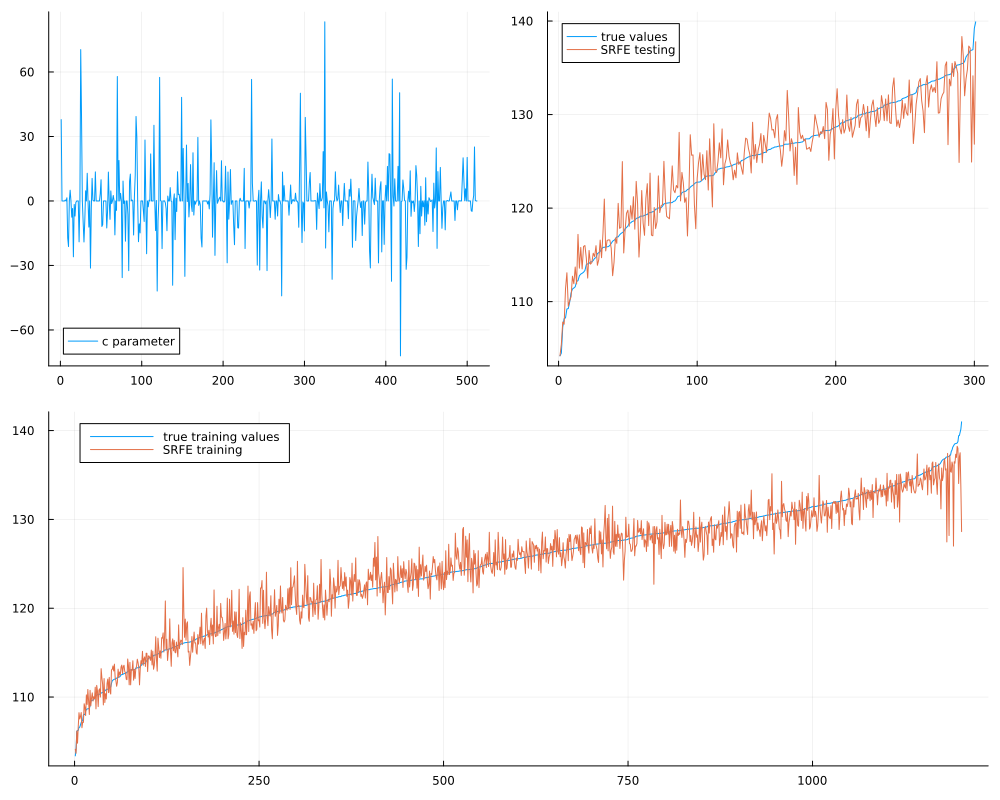

In [15]:
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[sortperm(ytrain)], label="true training values")
plot!(ytrainpred[sortperm(ytrain)], label="SRFE training")
p3 = plot(ytest[sortperm(ytest)], label="true values")
plot!(ytestpred[sortperm(ytest)], label="SRFE testing")
p4 = plot(p1,p3,layout=2, size = (1000,400))
plot(p4,p2,layout=(2,1) ,size=(1000,800))

In [43]:
trials = 5
N = [2^6, 2^7, 2^8, 2^9, 2^10, 2^11, 2^12]
λ = 0.015
quant = MSQ(K=2)
for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=82.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 64: 

avg. test error: 0.02815710091332248 avg. train error: 0.027848120287617684
abs. test error:3.5225042224099568 abs. train error: 3.460275293127554
mse. test error:20.446845528330847 mse train error: 19.30593833228517
rel mse test error:0.03601483358089438 rel mse train error: 0.03508893527928049
current iter: 128: 

avg. test error: 0.023473645698066602 avg. train error: 0.02208834560361152
abs. test error:2.9467196749256437 abs. train error: 2.755139024286841
mse. test error:14.88128194120399 mse train error: 12.65605454126023
rel mse test error:0.030766454151427907 rel mse train error: 0.02844860920496779
current iter: 256: 

avg. test error: 0.020424826590717392 avg. train error: 0.01844191124084836
abs. test error:2.5627443084831105 abs. train error: 2.3011092699207003
mse. test error:11.437007616721653 mse train error: 8.933835632687707
rel mse test error:0.026964548644267346 rel mse train error: 0.0239122177401098
current iter: 512

: avg. test error: 0.018616321760702978 avg. train error: 0.014719047014450298
abs. test error:2.3315080660760885 abs. train error: 1.8371362039015537
mse. test error:9.423122810647282 mse train error: 5.790049384256725
rel mse test error:0.0244679664034329 rel mse train error: 0.019221348870496296
current iter: 1024: 

avg. test error: 0.017237847775290263 avg. train error: 0.011859814295344913
abs. test error:2.162965500787217 abs. train error: 1.4812999693146618
mse. test error:8.404940340216811 mse train error: 3.842029270996219
rel mse test error:0.023126242367749645 rel mse train error: 0.015685292374018146
current iter: 2048

: avg. test error: 0.015487033128279296 avg. train error: 0.009736916548899474
abs. test error:1.940841980408008 abs. train error: 1.2164040467282906
mse. test error:6.823175414966149 mse train error: 2.61305862010708
rel mse test error:0.020832382210752377 rel mse train error: 0.012934285286222952
current iter: 4096

: avg. test error: 0.014053859261624817 avg. train error: 0.007830356960704917
abs. test error:1.7616391764595085 abs. train error: 0.9777320289241398
mse. test error:5.560756199864595 mse train error: 1.7275536206858022
rel mse test error:0.01878784484023431 rel mse train error: 0.010518555896999132


In [28]:
trials = 5
N = [2^6, 2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.015
quant = qsrfe.MSQ(K=2)
for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=82.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 64: avg. test error: 0.030597973047630088 avg. train error: 0.029025016058031504
abs. test error:3.8031829437741016 abs. train error: 3.5852682950717236
mse. test error:24.731684134324553 mse train error: 21.138503328719217
rel mse test error:0.03963639806640314 rel mse train error: 0.03674445873247499
current iter: 128: avg. test error: 0.02526270808726333 avg. train error: 0.022843552892418975
abs. test error:3.1423620461180954 abs. train error: 2.8324904688567374
mse. test error:16.469864049082368 mse train error: 13.080799925483586
rel mse test error:0.032331542730119636 rel mse train error: 0.028922189459306767
current iter: 256: avg. test error: 0.02139114458905505 avg. train error: 0.017567454423420687
abs. test error:2.6653304309938965 abs. train error: 2.1811428164848268
mse. test error:12.425942741625487 mse train error: 7.823500360066724
rel mse test error:0.02811040875863279 rel mse train error: 0.022369244398417483
current iter: 512: avg. test error: 0.018400

In [30]:
#another hyperparameter tuning cell for quantized model
trials = 5
N = [2^6, 2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.00014
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=82.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 64: avg. test error: 0.04426120050594997 avg. train error: 0.044301601453073894
abs. test error:5.469859623681647 abs. train error: 5.448132658013959
mse. test error:45.659892207619734 mse train error: 45.16036440277912
rel mse test error:0.053899393630525004 rel mse train error: 0.05376316157716804
current iter: 128: avg. test error: 0.04167709192248652 avg. train error: 0.04174866420165992
abs. test error:5.1568405952226986 abs. train error: 5.140432469828321
mse. test error:41.945714298553426 mse train error: 40.34611993948268
rel mse test error:0.05162224221948221 rel mse train error: 0.05077982920389348
current iter: 256: avg. test error: 0.04063523496219621 avg. train error: 0.04032474781040889
abs. test error:5.0248073330600045 abs. train error: 4.964016418053084
mse. test error:39.87327806700916 mse train error: 39.00647028499612
rel mse test error:0.050348195272766086 rel mse train error: 0.04996850116461423
current iter: 512: avg. test error: 0.03873370198370307

In [31]:
#another hyperparameter tuning cell for quantized model
trials = 5
N = [2^15]
λ = 0.00014
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=82.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 32768: avg. test error: 0.013149601266427577 avg. train error: 0.00852287139186547
abs. test error:1.6390427861561765 abs. train error: 1.0658619994747658
mse. test error:5.50442305104363 mse train error: 2.3001453530325726
rel mse test error:0.018715569148347135 rel mse train error: 0.012137230030033369


In [26]:
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5


N = [2^13]
λ = 0.00014

for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=82.0,intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 8192: avg. test error: 0.016082551093481272 avg. train error: 0.011905640597871607
abs. test error:2.001932545028596 abs. train error: 1.4830075287452025
mse. test error:8.138770849656996 mse train error: 3.965197592632041
rel mse test error:0.022725229465914636 rel mse train error: 0.015932453548347797


In [34]:
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5


N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13]
λ = 0.00014
for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=82.0,intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 128: avg. test error: 0.04472749796514035 avg. train error: 0.0448466180706472
abs. test error:5.527902651578428 abs. train error: 5.514732364335856
mse. test error:45.91571981603788 mse train error: 45.66137870675471
rel mse test error:0.054052540844501416 rel mse train error: 0.05406938489171775
current iter: 256: avg. test error: 0.04172882883599345 avg. train error: 0.040944329058566556
abs. test error:5.157390123126814 abs. train error: 5.038604514762261
mse. test error:41.90890196131805 mse train error: 40.257283355547294
rel mse test error:0.05163162491581717 rel mse train error: 0.050755285366973865
current iter: 512: avg. test error: 0.03898556947636718 avg. train error: 0.03813668987973827
abs. test error:4.824676414677073 abs. train error: 4.692084088437913
mse. test error:37.56524404799174 mse train error: 35.67840293708132
rel mse test error:0.048879280909649346 rel mse train error: 0.04779522893495749
current iter: 1024: avg. test error: 0.03285640775994781 

In [35]:
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5


N = [2^14]
λ = 0.00014
for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=82.0,intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 16384: avg. test error: 0.013724630034979151 avg. train error: 0.009491042881474612
abs. test error:1.7163734270130875 abs. train error: 1.1858604721595367
mse. test error:5.794656254374738 mse train error: 2.7168658199481444
rel mse test error:0.019201633332520895 rel mse train error: 0.013190041263930242


In [36]:
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5


N = [2^16]
λ = 0.00014
for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=82.0,intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 65536: avg. test error: 0.012940099269766197 avg. train error: 0.008434073303406144
abs. test error:1.619297073979343 abs. train error: 1.0553939284894
mse. test error:5.216717395867906 mse train error: 2.283655969154846
rel mse test error:0.01821934546356158 rel mse train error: 0.012092838460290144


In [103]:
quant = βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5


N = [2^7, 2^8, 2^9, 2^10, 2^11, 2^12, 2^13]
λ = 0.00014
q
for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=82.0,intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 128: 

avg. test error: 0.2976124113639024 avg. train error: 0.3061396923594983
abs. test error:6.363537028590335 abs. train error: 5.740063733849227
mse. test error:75.42050962345012 mse train error: 61.15580806106426
rel mse test error:0.03600833766238233 rel mse train error: 0.017653087111934116
current iter: 256: 

avg. test error: 0.21392496327461658 avg. train error: 0.2279657592947876
abs. test error:4.602415446575003 abs. train error: 4.3333423301332115
mse. test error:39.659350178020176 mse train error: 35.02984139773972
rel mse test error:0.026003453360424773 rel mse train error: 0.013277131194257196
current iter: 512

: avg. test error: 0.1881920845847557 avg. train error: 0.1816982172915609
abs. test error:3.9671376834317016 abs. train error: 3.456535376918547
mse. test error:28.404382317222478 mse train error: 21.069525323840292
rel mse test error:0.022141673779735874 rel mse train error: 0.01037785089637977
current iter: 1024: 

avg. test error: 0.15283940240703536 avg. train error: 0.14149826960830977
abs. test error:3.1925701982204933 abs. train error: 2.6605871574216318
mse. test error:19.281131692677125 mse train error: 12.418773487169396
rel mse test error:0.0182475267923876 rel mse train error: 0.007972500019638304
current iter: 2048: 

avg. test error: 0.14210438587118457 avg. train error: 0.12389590561166115
abs. test error:2.9424037397266267 abs. train error: 2.364436166064073
mse. test error:16.551156009972495 mse train error: 9.780480954350555
rel mse test error:0.016906640877363887 rel mse train error: 0.00708152272450481
current iter: 4096: 

avg. test error: 0.1330806105287931 avg. train error: 0.11464903694946293
abs. test error:2.794717649159124 abs. train error: 2.202697148987197
mse. test error:14.915082039405316 mse train error: 8.553429482120109
rel mse test error:0.01606767770245907 rel mse train error: 0.0066240754615799965
current iter: 8192: 

avg. test error: 0.13260618156506837 avg. train error: 0.11634847893155575
abs. test error:2.7651599107048503 abs. train error: 2.213096555055008
mse. test error:15.007248761946158 mse train error: 8.553745970919493
rel mse test error:0.01611604101371106 rel mse train error: 0.006623532659826803
current iter: 16384

: avg. test error: 0.13306873323529497 avg. train error: 0.11435045111702458
abs. test error:2.8076703587110976 abs. train error: 2.2117927524633463
mse. test error:15.072324500877992 mse train error: 8.601928091602463
rel mse test error:0.016150719301890867 rel mse train error: 0.006643646558649072


In [109]:
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
function objective(trial)
    @unpack λ, σ2 = trial
    model = qsrfe.srfeRegressor(N=2^10,λ=λ, σ2=σ2,intercept=false)
    c = qsrfe.fit(model,xtrain,ytrain,quant;verbose=false)
    ytestpred = qsrfe.predict(model,xtest,quant)
    return qsrfe.mse(ytest,ytestpred)
end

scenario = Scenario(λ = (0.000000001..0.0001),
                        σ2 = (10.0..10.0),
                        max_trials = 100);

HyperTuning.optimize(objective, scenario)

Scenario: evaluated 100 trials.
          parameters: λ, σ2
   space cardinality: Huge!
           instances: 1
          batch_size: 28
             sampler: BCAPSampler{Random.Xoshiro}
              pruner: NeverPrune
          max_trials: 100
           max_evals: 100
         stop_reason: HyperTuning.BudgetExceeded("Due to max_trials")
          best_trial: 
┌───────────┬───────────┐
│     Trial │     Value │
│        68 │           │
├───────────┼───────────┤
│         λ │ 1.0748e-5 │
│        σ2 │      10.0 │
│    Pruned │     false │
│   Success │     false │
│ Objective │   12.1395 │
└───────────┴───────────┘


In [131]:
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12,2^13]
λ = 0.00001

for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=10.0,intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: avg. test error: 0.03951691404190618 avg. train error: 0.039884757013407754
abs. test error:4.8972763582552545 abs. train error: 4.911331825260101
mse. test error:43.10464450236736 mse train error: 42.5575416563738
rel mse test error:0.05180450266015111 rel mse train error: 0.05154046775297592
current iter: 512: avg. test error: 0.028055000759098475 avg. train error: 0.028130660115323225
abs. test error:3.507574484281649 abs. train error: 3.4914720323455426
mse. test error:20.489741003865102 mse train error: 20.63640110864653
rel mse test error:0.035979858456017776 rel mse train error: 0.036231535441740716
current iter: 1024: avg. test error: 0.022151962624427715 avg. train error: 0.02266606919022969
abs. test error:2.7829935765532356 abs. train error: 2.8213412715025163
mse. test error:13.577329085665246 mse train error: 13.638065874272632
rel mse test error:0.029394873823698466 rel mse train error: 0.029555428558400976
current iter: 2048: avg. test error: 0.0205356

In [132]:
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12,2^13]
λ = 0.00001

for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: avg. test error: 0.046117090959415276 avg. train error: 0.04697981335438907
abs. test error:5.725217656392386 abs. train error: 5.8007958873590555
mse. test error:62.40323913154939 mse train error: 66.13884257650348
rel mse test error:0.05933128205705755 rel mse train error: 0.06075758925949905
current iter: 512: avg. test error: 0.028220203921347116 avg. train error: 0.028229820001613178
abs. test error:3.541192222244695 abs. train error: 3.5157225903285165
mse. test error:20.50563632730404 mse train error: 20.292105275231773
rel mse test error:0.036073510776706355 rel mse train error: 0.03601789498809737
current iter: 1024: avg. test error: 0.022497918588392684 avg. train error: 0.022466989219092966
abs. test error:2.8215463192396943 abs. train error: 2.8003509113938034
mse. test error:13.999765757652531 mse train error: 13.495102728497525
rel mse test error:0.02984974689934806 rel mse train error: 0.02939734874545687
current iter: 2048: avg. test error: 0.02052880

In [133]:
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^14]
λ = 0.00001

for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 16384: avg. test error: 0.018827838987833627 avg. train error: 0.017202302415309723
abs. test error:2.3636935242522155 abs. train error: 2.1448569742651147
mse. test error:10.050387201160023 mse train error: 7.917675848740269
rel mse test error:0.02528928202787568 rel mse train error: 0.02251347730547465


In [134]:
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.00012

for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=10.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: avg. test error: 0.029282649389378544 avg. train error: 0.02898530257253242
abs. test error:3.6717340173593143 abs. train error: 3.607449026704201
mse. test error:22.578248532429093 mse train error: 21.91667321629189
rel mse test error:0.03778335461207663 rel mse train error: 0.037381249000212946
current iter: 512: avg. test error: 0.025099698297701794 avg. train error: 0.02520094125613938
abs. test error:3.1506100508335035 abs. train error: 3.1398351835732172
mse. test error:16.891453912653464 mse train error: 16.84760994505322
rel mse test error:0.03277732039331034 rel mse train error: 0.03283630940003022
current iter: 1024: avg. test error: 0.022599277541736497 avg. train error: 0.022965089748933225
abs. test error:2.8404955483189314 abs. train error: 2.861007362856099
mse. test error:13.978946554026674 mse train error: 13.900836990700924
rel mse test error:0.029826324794096436 rel mse train error: 0.02983008293692434
current iter: 2048: avg. test error: 0.0219812

In [208]:
quant = βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12, 2^13]
λ = 0.00012

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: 

avg. test error: 0.23437025112226442 avg. train error: 0.2431004414634744
abs. test error:5.0063441177625405 abs. train error: 4.540463587983439
mse. test error:46.6889701297148 mse train error: 38.06281665615749
rel mse test error:0.028156254133260766 rel mse train error: 0.013758518123526816
current iter: 512: 

avg. test error: 0.19688262976150145 avg. train error: 0.19406768427727134
abs. test error:4.162422260569583 abs. train error: 3.69855866921923
mse. test error:32.620336988695 mse train error: 23.608748929576144
rel mse test error:0.02371621281860985 rel mse train error: 0.01096271509880729
current iter: 1024: 

avg. test error: 0.1532531281239115 avg. train error: 0.14795891527112745
abs. test error:3.1633454213501144 abs. train error: 2.808089819038362
mse. test error:18.856599440887116 mse train error: 13.719885930086424
rel mse test error:0.018040610908788456 rel mse train error: 0.008366523015686304
current iter: 2048

: avg. test error: 0.1252024150400769 avg. train error: 0.10478578607359443
abs. test error:2.4826448382146733 abs. train error: 1.9281170624870363
mse. test error:12.100379888780305 mse train error: 6.279035731386459
rel mse test error:0.01446498083631199 rel mse train error: 0.005670564465110426
current iter: 4096

: avg. test error: 0.1017609612990454 avg. train error: 0.08053443639161996
abs. test error:2.041955750807574 abs. train error: 1.4755889464486158
mse. test error:8.719942977195391 mse train error: 3.923051890394052
rel mse test error:0.012275466233413548 rel mse train error: 0.004486479642276916
current iter: 8192

: avg. test error: 0.10360950536200804 avg. train error: 0.07459993440736697
abs. test error:2.07469458946719 abs. train error: 1.36915240644423
mse. test error:8.393433693149195 mse train error: 3.307632871668872
rel mse test error:0.012048303235521161 rel mse train error: 0.004119776958119501
current iter: 16384: 

avg. test error: 0.09678177223913845 avg. train error: 0.07344301904507618
abs. test error:1.9595511874355593 abs. train error: 1.3492452541071962
mse. test error:7.61015686614185 mse train error: 3.2692440314498343
rel mse test error:0.011477174283484066 rel mse train error: 0.004095318689011897


In [114]:
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11]
λ = 0.00001

for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: avg. test error: 0.04101932670933328 avg. train error: 0.042293367104921174
abs. test error:5.08176158960933 abs. train error: 5.214521534700806
mse. test error:46.851539427104925 mse train error: 48.734761890154246
rel mse test error:0.05285411874999011 rel mse train error: 0.05417873152627313
current iter: 512: avg. test error: 0.027144258486901086 avg. train error: 0.027086469948447284
abs. test error:3.402382577772122 abs. train error: 3.369686922101377
mse. test error:19.482149555997175 mse train error: 19.084757516350457
rel mse test error:0.035170474180078015 rel mse train error: 0.03491786019258868
current iter: 1024: avg. test error: 0.022259085055644355 avg. train error: 0.022606610182432138
abs. test error:2.792220353473144 abs. train error: 2.8147573214122437
mse. test error:13.88447557595162 mse train error: 13.279241955642823
rel mse test error:0.02972239849222546 rel mse train error: 0.02916149982953135
current iter: 2048: avg. test error: 0.0206694667

In [115]:
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^12,2^13]
λ = 0.00001

for n in N
    print("current iter: ",n,": ")
    model = qsrfe.srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 4096: avg. test error: 0.01932689504405574 avg. train error: 0.01868219812892732
abs. test error:2.427303277112292 abs. train error: 2.326720963292617
mse. test error:10.593337584253042 mse train error: 9.360192687049627
rel mse test error:0.02595796158863048 rel mse train error: 0.0244827910907476
current iter: 8192: avg. test error: 0.01921702345394196 avg. train error: 0.01778983894608358
abs. test error:2.4115946375222967 abs. train error: 2.2172803220559474
mse. test error:10.609868128556627 mse train error: 8.451493473841467
rel mse test error:0.02598088534634982 rel mse train error: 0.02326529448148988


In [ ]:
# rfe quantized the second

In [70]:
#test cell for hyperparameter testing quantized version
# 2^7 = 128, 2^8 = 256, 2^9 = 512, 2^10 =1024, 2^11 = 2048, 2^12 4096, 2^13 8192, 2^14 = 16384, 2^15 = 32768
#N = [2^6, 2^7, 2^8, 2^9, 2^10, 2^11, 2^12]
N = 2^14
λ = 0.0000015

quant = qsrfe.βQ(K=2,β=1.5,λ=32,limit=1.0,condense=true)

model = qsrfe.rfeRegressor(N=N,λ=λ, σ2=82.0, intercept=true)

c = qsrfe.fit(model,xtrain,ytrain,quant;verbose=true) #max_iter=2000000,
ytrainpred = qsrfe.predict(model,xtrain,quant)
ytestpred = qsrfe.predict(model,xtest,quant);

println("")
println("rel: ",qsrfe.rel_error(ytest,ytestpred)," train rel: ",qsrfe.rel_error(ytrain,ytrainpred))
println("abs: ",qsrfe.abs_error(ytest,ytestpred)," train abs: ",qsrfe.abs_error(ytrain,ytrainpred))
println("mse: ",qsrfe.mse(ytest,ytestpred)," train mse: ",qsrfe.mse(ytrain,ytrainpred))

support: 513/513
rel: 0.014622276645057442 train rel: 0.008161831169526772
abs: 1.816677915866272 train abs: 1.0216668135393072
mse: 6.492575590164054 train mse: 2.142409423718075


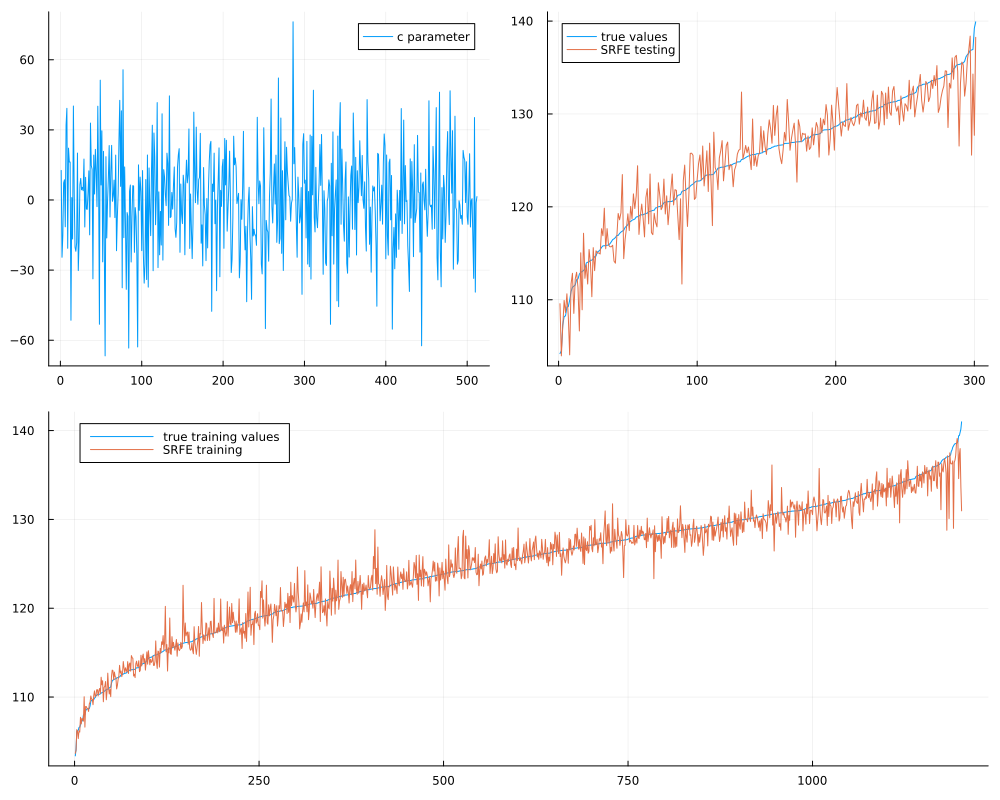

In [56]:
# plot results
p1 = plot(c[1:(end - model.intercept)],label="c parameter")
p2 = plot(ytrain[sortperm(ytrain)], label="true training values")
plot!(ytrainpred[sortperm(ytrain)], label="SRFE training")
p3 = plot(ytest[sortperm(ytest)], label="true values")
plot!(ytestpred[sortperm(ytest)], label="SRFE testing")
p4 = plot(p1,p3,layout=2, size = (1000,400))
plot(p4,p2,layout=(2,1) ,size=(1000,800))

In [125]:
# RFE QUANTIZED

quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
function objective(trial)
    @unpack λ, σ2 = trial
    model = qsrfe.rfeRegressor(N=2^12,λ=λ, σ2=σ2,intercept=false)
    c = qsrfe.fit(model,xtrain,ytrain,quant;verbose=false)
    ytestpred = qsrfe.predict(model,xtest,quant)
    return qsrfe.mse(ytest,ytestpred)
end

scenario = Scenario(λ = (0.00000001..0.00000001),
                        σ2 = (30.0..80.0),
                        max_trials = 100);

HyperTuning.optimize(objective, scenario)

Scenario: evaluated 100 trials.
          parameters: λ, σ2
   space cardinality: Huge!
           instances: 1
          batch_size: 28
             sampler: BCAPSampler{Random.Xoshiro}
              pruner: NeverPrune
          max_trials: 100
           max_evals: 100
         stop_reason: HyperTuning.BudgetExceeded("Due to max_trials")
          best_trial: 
┌───────────┬─────────┐
│     Trial │   Value │
│        79 │         │
├───────────┼─────────┤
│         λ │  1.0e-8 │
│        σ2 │ 30.9033 │
│    Pruned │   false │
│   Success │   false │
│ Objective │ 7.60485 │
└───────────┴─────────┘


In [75]:

trials = 5
N = [2^8,2^9,2^10,2^11,2^12,2^13,2^14]

λ = 0.0000015
quant = qsrfe.βQ(K=2,β=1.5,λ=32,limit=1.0,condense=true)

i = 0
for n in N
    i+=1
    print("current iter: ",n,": ")
    model = qsrfe.rfeRegressor(N=n,λ=λ * ((√(2))^(i-7)), σ2=82.0, intercept=true)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: here:43.32447825461568
here:45.70808721454126
here:44.75457274738868
here:32.31900118833851
here:41.48252605549604
avg. test error: 0.04191103854798423 avg. train error: 0.04111665403893825
abs. test error:5.188670065919796 abs. train error: 5.067257600669814
mse. test error:41.51773309207603 mse train error: 40.26655206975677
rel mse test error:0.051314654957836006 rel mse train error: 0.050693701457022934
current iter: 512: here:38.71352962914048
here:36.21558702858365
here:37.87034857766307
here:35.558130879856236
here:37.72566646741665
avg. test error: 0.03881127077625677 avg. train error: 0.03755654685380855
abs. test error:4.800638724996956 abs. train error: 4.625772480213056
mse. test error:37.21665251653202 mse train error: 34.17383189062923
rel mse test error:0.04866672701712341 rel mse train error: 0.046764772285256814
current iter: 1024: here:31.233089394900755
here:28.081499323285026
here:29.49130068073728
here:28.32181247854703
here:23.971202286919404
av

In [122]:
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8,2^9,2^10,2^11,2^12,2^13]
λ = 0.000000001
i = 0
for n in N
    i=+1
    print("current iter: ",n,": ")
    model = qsrfe.rfeRegressor(N=n,λ=λ * (√(2))^(i-5), σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: avg. test error: 0.04750045506390301 avg. train error: 0.04885539848964916
abs. test error:5.863703558728351 abs. train error: 5.997597198114883
mse. test error:65.89378039809952 mse train error: 68.87005683442867
rel mse test error:0.0628336716960177 rel mse train error: 0.0639666786213587
current iter: 512: avg. test error: 0.028425901054674248 avg. train error: 0.02840014718205247
abs. test error:3.5528086591860957 abs. train error: 3.5290427190269886
mse. test error:20.923729938780678 mse train error: 20.541228504747217
rel mse test error:0.03647186289139902 rel mse train error: 0.036261219938806835
current iter: 1024: avg. test error: 0.022934285710818708 avg. train error: 0.023042941826730924
abs. test error:2.875169965278284 abs. train error: 2.869151018174759
mse. test error:14.265928291599167 mse train error: 13.865160396006399
rel mse test error:0.030128016804686665 rel mse train error: 0.029792271636892725
current iter: 2048: avg. test error: 0.02016433017

In [123]:
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8,2^9,2^10,2^11,2^12,2^13,2^14]
λ = 0.00000001
i = 0
for n in N
    i=+1
    print("current iter: ",n,": ")
    model = qsrfe.rfeRegressor(N=n,λ=λ * (√(2))^(i-5), σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: avg. test error: 0.04523681167679085 avg. train error: 0.04456060080644445
abs. test error:5.616833727774011 abs. train error: 5.497911160195883
mse. test error:55.23925384382263 mse train error: 55.27249928805891
rel mse test error:0.05800427964098258 rel mse train error: 0.05811403783805913
current iter: 512: avg. test error: 0.028608433313404548 avg. train error: 0.028754518662917387
abs. test error:3.5811675720161773 abs. train error: 3.572175300374004
mse. test error:21.456522826060535 mse train error: 21.115909490450377
rel mse test error:0.03690424823356546 rel mse train error: 0.036726845396445856
current iter: 1024: avg. test error: 0.022554824768722427 avg. train error: 0.02274833633101738
abs. test error:2.827990204327551 abs. train error: 2.8324436523278065
mse. test error:14.063671866420133 mse train error: 13.6175149293853
rel mse test error:0.029884540558188545 rel mse train error: 0.029520978800625104
current iter: 2048: avg. test error: 0.02046072182

In [126]:
quant = qsrfe.βQ(K=2,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8,2^9,2^10,2^11,2^12,2^13,2^14]
λ = 0.00000001
i = 0
for n in N
    i=+1
    print("current iter: ",n,": ")
    model = qsrfe.rfeRegressor(N=n,λ=λ * (√(2))^(i-5), σ2=40.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = qsrfe.trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: avg. test error: 0.2954716826517897 avg. train error: 0.2971904678626354
abs. test error:36.5043378307489 abs. train error: 36.639800126279006
mse. test error:2592.7764823204784 mse train error: 2515.3543962842864
rel mse test error:0.39434964424675134 rel mse train error: 0.3889684328126098
current iter: 512: avg. test error: 0.18789256182838016 avg. train error: 0.17728304975741496
abs. test error:23.284606975775052 abs. train error: 21.943052804496617
mse. test error:1007.0964778630708 mse train error: 903.3479607469993
rel mse test error:0.24767184652358543 rel mse train error: 0.23491445858169396
current iter: 1024: avg. test error: 0.07989274650686955 avg. train error: 0.07716533057673008
abs. test error:9.795289401055268 abs. train error: 9.476622732386065
mse. test error:211.41695038305906 mse train error: 179.09447647651285
rel mse test error:0.11456884174746965 rel mse train error: 0.10557199837930964
current iter: 2048: avg. test error: 0.0341714721841503 

In [209]:
# no touch
quant = βQ(K=16,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.00012

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: 

avg. test error: 0.237286761825723 avg. train error: 0.2572395005357984
abs. test error:5.264907201917406 abs. train error: 4.897908536399326
mse. test error:54.220652395847615 mse train error: 43.402532613693175
rel mse test error:0.030378444283061756 rel mse train error: 0.014767023788555707
current iter: 512: 

avg. test error: 0.185852232193994 avg. train error: 0.18280075745668228
abs. test error:3.879084157627971 abs. train error: 3.399259824455045
mse. test error:27.70161818926427 mse train error: 20.439846847152616
rel mse test error:0.02185078489666162 rel mse train error: 0.010240005694636253
current iter: 1024: 

avg. test error: 0.15408432317077492 avg. train error: 0.13921414958535738
abs. test error:3.1108352403891435 abs. train error: 2.6285324250851727
mse. test error:17.126606339348417 mse train error: 12.10949937569836
rel mse test error:0.017214562198119454 rel mse train error: 0.007875766828947677
current iter: 2048

: avg. test error: 0.1161906880264119 avg. train error: 0.10152235174721176
abs. test error:2.318726528456171 abs. train error: 1.8647606451275032
mse. test error:10.622918543033084 mse train error: 5.883566854230435
rel mse test error:0.013555834715057908 rel mse train error: 0.0054940355164673545
current iter: 4096: 

avg. test error: 0.10356226692610726 avg. train error: 0.08247483674221626
abs. test error:2.0824262249357117 abs. train error: 1.5142657050913042
mse. test error:8.36814044026929 mse train error: 4.034821535157865
rel mse test error:0.012038663259016164 rel mse train error: 0.004549603072793977
current iter: 8192: 

avg. test error: 0.10116194579394411 avg. train error: 0.074697527987199
abs. test error:2.013664731321107 abs. train error: 1.365685931473884
mse. test error:7.936854645908928 mse train error: 3.3255087375248458
rel mse test error:0.011721824662265378 rel mse train error: 0.0041306395031705774
current iter: 16384

: avg. test error: 0.09859143211345228 avg. train error: 0.07208890387082614
abs. test error:1.9957828901810704 abs. train error: 1.3129452616470214
mse. test error:7.710303162288855 mse train error: 3.153313342267636
rel mse test error:0.011556409231972042 rel mse train error: 0.004022868668949679


In [210]:
quant = βQ(K=256,β=1.5,λ=32,condense=true)
#model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.00012

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

current iter: 256: 

avg. test error: 0.23468144522861292 avg. train error: 0.24996488015897644
abs. test error:5.114834806202557 abs. train error: 4.686788859661567
mse. test error:51.35580635119591 mse train error: 40.32001548026285
rel mse test error:0.02975080221209605 rel mse train error: 0.014323898106646513
current iter: 512

: avg. test error: 0.18675920830321036 avg. train error: 0.1793309447789048
abs. test error:3.9384601324848303 abs. train error: 3.404669648589202
mse. test error:29.070344523345238 mse train error: 21.336032834589634
rel mse test error:0.022312081460817035 rel mse train error: 0.010409157070120256
current iter: 1024: 

avg. test error: 0.14709194921388583 avg. train error: 0.1382547873422462
abs. test error:3.043409283174269 abs. train error: 2.5567541489785035
mse. test error:19.011567728427007 mse train error: 11.45955218870169
rel mse test error:0.018117370373546444 rel mse train error: 0.007665761038516869
current iter: 2048

: avg. test error: 0.12935463355731044 avg. train error: 0.10264210369213718
abs. test error:2.553685384929559 abs. train error: 1.8866352327179314
mse. test error:12.876061035808055 mse train error: 6.0146282763180015
rel mse test error:0.014916676805988089 rel mse train error: 0.005551615003178987
current iter: 4096

: avg. test error: 0.10267543332366899 avg. train error: 0.08171628548066492
abs. test error:2.0965629325998636 abs. train error: 1.4950183912487227
mse. test error:8.514347649371562 mse train error: 3.924187460088729
rel mse test error:0.01214015224473117 rel mse train error: 0.004486313342251396
current iter: 8192

: avg. test error: 0.09966449850906674 avg. train error: 0.0731071934967602
abs. test error:2.010103577444936 abs. train error: 1.3408925496382813
mse. test error:8.213344306721265 mse train error: 3.239101484460052
rel mse test error:0.011927224708307942 rel mse train error: 0.004077097413875764
current iter: 16384: 

avg. test error: 0.09834454022201612 avg. train error: 0.07234925788420413
abs. test error:1.978140557432268 abs. train error: 1.32637191506547
mse. test error:7.689430339816044 mse train error: 3.15669350721098
rel mse test error:0.011538918990304573 rel mse train error: 0.004024982122504288


In [ ]:
λ │ 4.05826e-5 │
│        σ2 │    61.8018 │
model = srfeRegressor(N=N,λ=λ, σ2=10.0)
trials = 5
N = [2^8, 2^9, 2^10, 2^11, 2^12, 2^13, 2^14]
λ = 0.00012

for n in N
    print("current iter: ",n,": ")
    model = srfeRegressor(N=n,λ=λ, σ2=10.0)
    reltesterror, reltrainerror, abstesterror, abstrainerror, msetesterror, msetrainerror, relmsetesterror, relmsetrainerror = trainandevaluate(model,quant,(xtrain, xtest), (ytrain, ytest);trials=trials)
    println("avg. test error: ",reltesterror, " avg. train error: ", reltrainerror)
    println("abs. test error:", abstesterror, " abs. train error: ", abstrainerror)
    println("mse. test error:", msetesterror, " mse train error: ", msetrainerror)
    println("rel mse test error:", relmsetesterror, " rel mse train error: ", relmsetrainerror)
end

In [220]:
using MLJ
modelType = @load RandomForestRegressor pkg = "BetaML" verbosity=0 
model= modelType()
(fitResults, cache, report) = MLJ.fit(model, 0, xtrain, ytrain)


UndefVarError: UndefVarError: `predict` not defined

In [224]:

y_pred = MLJ.predict(model, fitResults, xtest)
y_trainpred = MLJ.predict(model, fitResults, xtrain)
println("mse: $(mse(ytest,y_pred)), mse train: $(mse(ytrain,y_trainpred))")


mse: 10.707091033791357, mse train: 1.2182977717392924
